In [1]:
%matplotlib inline
from python_speech_features import mfcc
from python_speech_features import logfbank
import scipy.io.wavfile as wav
from scipy import signal
import peakutils
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from scipy.cluster.vq import kmeans2,vq, whiten
from sklearn.cluster import KMeans
from hmmlearn.hmm import MultinomialHMM
from mpl_toolkits.mplot3d import Axes3D

In [2]:
def transform_to_str(pred):
    s = ''
    for i in pred:
        if i == 26:
            s += ' '
        else:
            s += chr(97 + i)
    return s

# Takes in sequential order of numpy arrays representing window for keypress 
# Outputs (keypress x 80) numpy array with cepstrum applied to it
def extract_cepstrum(keypress_sigs, rate, mfcc_start=2, mfcc_end=7):
    keypress_feats = []
    for keypress_sig in keypress_sigs:
        mfcc_feat = mfcc(keypress_sig, rate, winlen=0.01, 
        winstep=0.0025, numcep=16, nfilt=32, 
        lowfreq=400, highfreq=12000)
        keypress_feats.append(np.concatenate(mfcc_feat[mfcc_start:mfcc_end, :]).T)
    data = np.vstack(keypress_feats)
    return data

def run_hmm(data, targ_s, whiten_data=True, num_clusters=60, space_smooth=10, trans_smooth=1):
    if whiten_data:
        data = whiten(data)
    kmeans = KMeans(n_clusters=num_clusters).fit(data)

    # Get labels from running clustering
    labels = kmeans.labels_.reshape(-1, 1)

    # Init spaces to reasonable values
    space_inds = [i for i, letter in enumerate(targ_s) if letter == " "][:10]
    spaces = kmeans.labels_[space_inds]

    # Build transition matrix
    trans_m = np.zeros((27, 27)) + trans_smooth
    for i in range(len(targ_s)-1):
        c, next_c = ord(targ_s[i]) - 97, ord(targ_s[i+1]) - 97
        if c < 0:
            c = 26
        if next_c < 0:
            next_c = 26
        trans_m[c][next_c] += 1
    row_sums = trans_m.sum(axis=1)
    trans_m = trans_m / row_sums[:, np.newaxis]

    # Build emission matrix
    emiss_m = np.random.rand(27, num_clusters)
    space_vec = np.zeros((num_clusters)) + space_smooth
    for i in spaces:
        space_vec[i] += 1
    emiss_m[26, :] = space_vec
    row_sums = emiss_m.sum(axis=1)
    emiss_m = emiss_m / row_sums[:, np.newaxis]

    # Create HMM
    hmm = MultinomialHMM(n_components=27, verbose=True, init_params="e", params="se", tol=1e-4, n_iter=5000) 
    hmm.n_features = num_clusters
    hmm.transmat_ = trans_m
    hmm.emissionprob_ = emiss_m
    
    # Fit and decode
    hmm = hmm.fit(labels)
    logprob, pred = hmm.decode(labels, algorithm='viterbi')
    
    return hmm, logprob, pred

In [4]:
(rate,sig) = wav.read("alice_slow.wav")
sig = sig[:, 1]

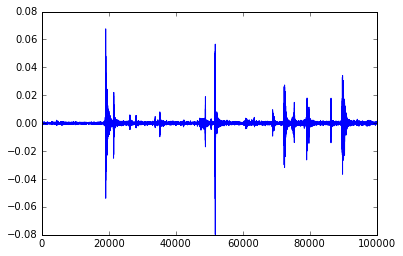

In [6]:
pd.Series(sig[500000:600000]).plot()

In [8]:
f, t, Sxx = signal.spectrogram(sig, rate)
# t -> X, time
# f -> Y, frequency in HZ
# Sxx -> C, actual values themselves

In [12]:
targ_s = "alice was beginning to get very tired of sitting by her sister on the bank and of having nothing to do once or twice she had peeped into the book her sister was reading but it had no pictures or conversations in it and what is the use of a book thought alice without pictures or conversations so she was considering in her own mind as well as she could for the day made her feel very sleepy and stupid whether the pleasure of making a daisy chain would be worth the trouble of getting up and picking the daisies when suddenly a white abbit with pink eyes ran close by her there was nothing so very remarkable in that nor did alice think it so very much out of the way to hear the rabbit say to itself oh dear oh dear i shall be too late but when the rabbit actually took a watch out of its waistcoat pocket and looked at it and then hurried on alice started to her feet for it flashed across her mind that she had never before seen a rabbit with either a waistcoat pocket or watch to take out of it and burning wit curiosity she ran acrross the field after it and was just in time to see it pop down a large rabbit hole under the hedge in another moment down went alice after it the rabbit hole went straight on like a tunnel for some way and then dipped sudddenly down so suddenly that alice had not a moment to think about stopping herself before she found herself falling down what seemed to be a very deep well either the well was very deep or she fell very slowly for she had plenty of time as she went down to look about her first she tried to make out what she was coming to but it was too dark to see anything then she looked at the sides of the wall and noticed that they were filled with cupboards and book shelves here and there she saw maps and pictures hung upon pegs she took down a jar from one of the shelves she passed it was labeled orange marmalade but to her great disappointment it was empty she did not like to drop the jar so managed to put it into one of the cupboardsa as she fell past it down down down would the fall never come to an end there was nothing ele to do"
sig_str = np.sum(Sxx[3:70, :], axis=0)
# According to paper, usually around 100ms left between 
# conseuctive keystrokes so min_dist should be around 20
# Difference between adjacent signals is 0.005ms
indexes = peakutils.indexes(sig_str, thres=0.008, min_dist=18)
print indexes
len(indexes), len(targ_s)

[   586    606    639 ..., 119013 119037 119068]


(2112, 2092)

(0, 10)

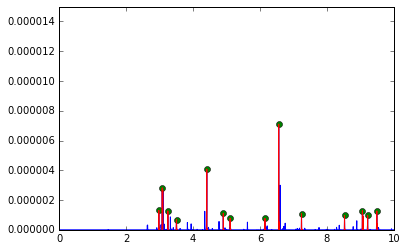

In [25]:
# # fig = plt.figure(figsize=(18, 18))
# plt.plot(t, sig_str)
# plt.plot(t[indexes], sig_str[indexes], 'o')

# keystroke_feats = []
# wave_len = 0.04
# for i in range(len(indexes)):
#     ind = indexes[i]
#     plt.plot(t[ind - 2: ind + 6], sig_str[ind - 2: ind + 6], 'r')
#     # Take exactly 40 ms
#     key_start = int(t[ind - 2] * rate)
#     key_end = int(key_start + wave_len * rate)
#     keypress_sig = sig[key_start:key_end]
#     mfcc_feat = mfcc(keypress_sig, rate, winlen=0.01, 
#     winstep=0.0025, numcep=16, nfilt=32, 
#     lowfreq=400, highfreq=12000)
#     keystroke_feats.append(np.concatenate(mfcc_feat[2:7, :]).T)
# data = np.vstack(keystroke_feats)
# data.shape
# plt.ylim(0, 1.5e-5)
# plt.xlim(0, 10)

In [ ]:
# Maybe just do some parameter tuning, try to maximize number of unique words found in set
# Find and extract all parameters that can be taken out
# Try to use dataframes
wave_len = 0.04
shift_start_back = 2

keypress_sigs = []
for i in range(len(indexes)):
    ind = indexes[i]
    # Take exactly 40 ms
    key_start = int(t[ind - shift_start_back] * rate)
    key_end = int(key_start + wave_len * rate)
    keypress_sigs.append(sig[key_start:key_end])        
data = extract_cepstrum(keypress_sigs, rate)

hmm, logprob, pred = run_hmm(data, targ_s)

         1       -8655.2861             +nan
         2       -8485.1626        +170.1235
         3       -8482.5419          +2.6207
         4       -8479.8958          +2.6462
         5       -8477.0704          +2.8254
         6       -8473.9491          +3.1213
         7       -8470.4165          +3.5326
         8       -8466.3514          +4.0651
         9       -8461.6221          +4.7292
        10       -8456.0929          +5.5293
        11       -8449.6666          +6.4262
        12       -8442.3558          +7.3108
        13       -8434.2453          +8.1106
        14       -8425.4024          +8.8428
        15       -8415.9062          +9.4962
        16       -8405.8894         +10.0168
        17       -8395.5311         +10.3583
        18       -8385.0334         +10.4977
        19       -8374.5981         +10.4353
        20       -8364.4067         +10.1914
        21       -8354.6047          +9.8020
        22       -8345.2931          +9.3116
        23

In [14]:
# Look at why scale is completely different between mike and mines
# Look at how Mike does things differently from you in general
# Experiment with windows
# Experiment with a more representative transition matrix
# Try experimenting with how far back you fall from the window

In [8]:
print np.exp(logprob/(len(pred)))
pred_str = transform_to_str(pred)
print pred_str

0.0145743074513
qxqy pplituqyyjupit allithe ocs s f ar ppore woflis wings ongr mangkere as herasend das bdot t ton dicingccker ricr ashaing tit d wallelo ind sllar pbowas by the da s dxzlee mabboot adere ong arcevere wngbooryy ve ite ippitheshallve the the f t we tour wa ared anondo t irassat lve t t t oncty wnthengnge mxbowabugeshe asjand theryuthasicotothed wooun bouthedzve tof pond sowangznd t her thce o war vxkerabbouthey tofzzkbut we ck unoly shelvhithjhelyvelor tituthe d t warer t sithzjbunt waf wit oory t she id ar t mqoucemas tof mas rellqcor ce icery as ndale ury pitshut mad corory whe bend oot shaby thelitowaller deyfouthaice sithe be sat alf as thackved werelashellfor se t win wnk s wabowheele andeangxf we tig bmathe dshathe pingce ollokeve she pofoflalf d ce wad wn ing she titoof pint ad he wang bule ing cowindd o wang here s thedorasllabung wnour anqve t vzzbe when oqqr f t alendd inmererhondithe ang wzalvy win tof ay s t r so tggbl asitoupbbo waqhegndo tury to s he shelqt